In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import os



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fahdaleem","key":"8431206e9871973994a63d5d2fd4c79c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown


In [6]:
!unzip /content/deepfake-and-real-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Setup a ViT model instance with pretrained weights

In [8]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['Real','Fake']

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 94.9MB/s]


In [9]:
!pip install torchinfo

In [10]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## Preprocess and load dataset


In [11]:
train_dir = '/content/Dataset/Train'
test_dir = '/content/Dataset/Test'

In [12]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [13]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [14]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


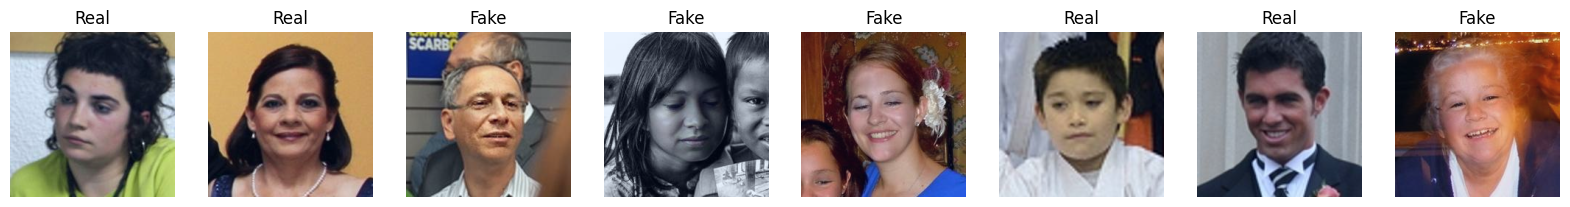

In [73]:
images, labels = next(iter(train_dataloader_pretrained))

# Plot sample images and their class labels
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
for idx in range(8):
    img = images[idx]
    label = labels[idx]

    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    axes[idx].imshow(img)
    axes[idx].set_title(class_names[label])
    axes[idx].axis('off')

plt.show()


## Training

In [17]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0

    pbar = tqdm(dataloader, desc="Training", leave=False)

    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        acc = (y_pred_class == y).sum().item() / len(y_pred)
        train_acc += acc
        pbar.set_postfix({'Batch Loss': f'{loss.item():.4f}', 'Batch Acc': f'{acc:.4f}'})

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        pbar = tqdm(dataloader, desc="Testing", leave=False)
        for X, y in pbar:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss.item()

            preds = logits.argmax(dim=1)
            acc = (preds == y).sum().item() / len(preds)
            test_acc += acc

            pbar.set_postfix({'Batch Loss': f'{loss.item():.4f}', 'Batch Acc': f'{acc:.4f}'})

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/4376 [00:00<?, ?it/s]

Testing:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3491 | train_acc: 0.8466 | test_loss: 0.5388 | test_acc: 0.7535


Training:   0%|          | 0/4376 [00:00<?, ?it/s]

Testing:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.3236 | train_acc: 0.8603 | test_loss: 0.5626 | test_acc: 0.7504


Training:   0%|          | 0/4376 [00:00<?, ?it/s]

Testing:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.3211 | train_acc: 0.8620 | test_loss: 0.6109 | test_acc: 0.7460


Training:   0%|          | 0/4376 [00:00<?, ?it/s]

Testing:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3201 | train_acc: 0.8623 | test_loss: 0.6277 | test_acc: 0.7376


Training:   0%|          | 0/4376 [00:00<?, ?it/s]

Testing:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3202 | train_acc: 0.8622 | test_loss: 0.5924 | test_acc: 0.7526


## Plot performance

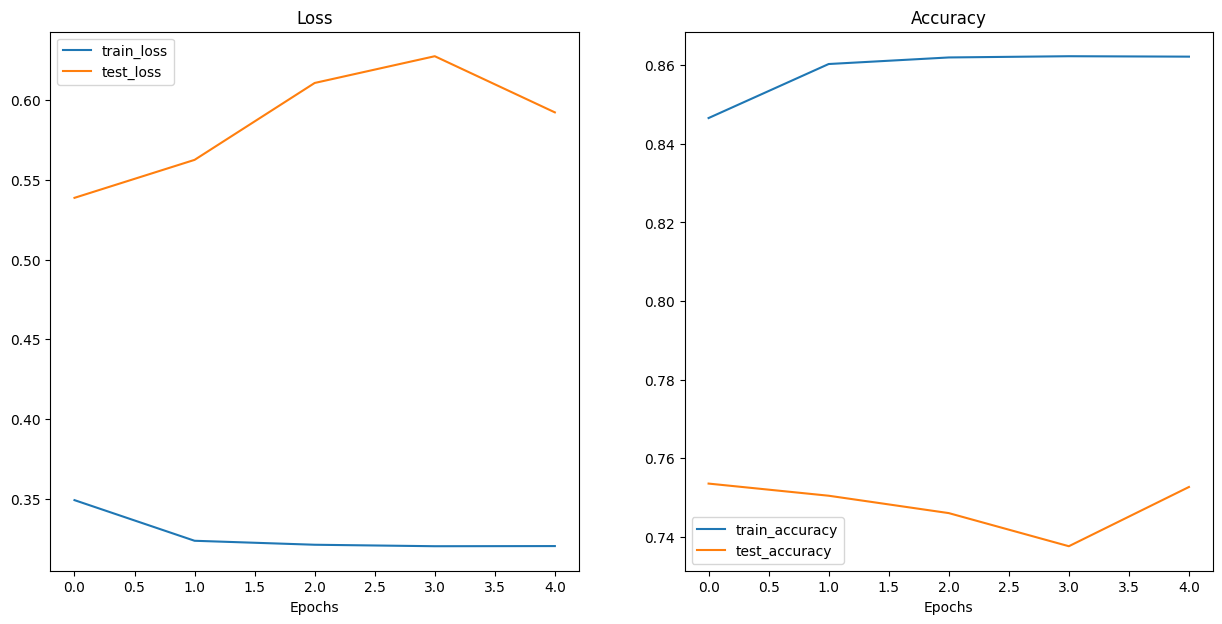

In [18]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(pretrained_vit_results)

# Make Predictions on a few images

In [19]:
from PIL import Image

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

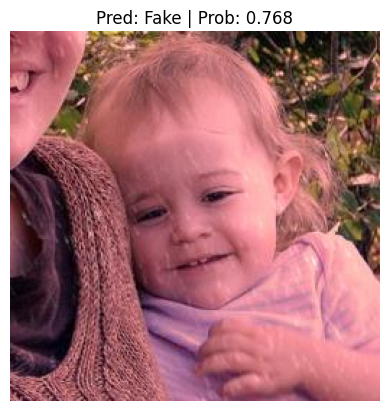

In [63]:
custom_image_path = "/content/Dataset/Test/Fake/fake_3.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

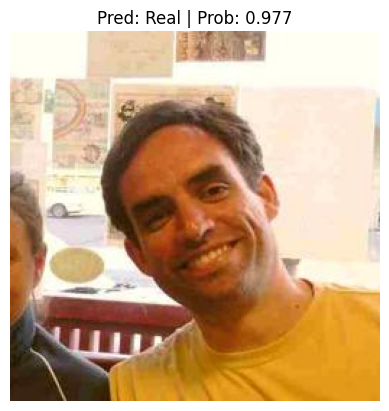

In [59]:
custom_image_path = "/content/Dataset/Test/Real/real_5.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)